# Optional Assigment - Exploring overfitting in NLP
When looking at a number of different types of layer for text classification this week you saw many examples of overfitting -- with one of the major reasons for the overfitting being that your training dataset was quite small, and with a small number of words. Embeddings derived from this may be over generalized also. So for this week’s exercise you’re going to train on a large dataset, as well as using transfer learning of an existing set of embeddings.

The dataset is from:  https://www.kaggle.com/kazanova/sentiment140. I’ve cleaned it up a little, in particular to make the file encoding work with Python CSV reader. 

The embeddings that you will transfer learn from are called the GloVe, also known as Global Vectors for Word Representation, available at: https://nlp.stanford.edu/projects/glove/

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [4]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

# training_cleaned.csv
# !gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

In [5]:
num_sentences = 0

with open("./data/training_cleaned.csv", encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        ### START CODE HERE
        #Create list items where the first item is the text, found in row[5], and the second is the label.
        # Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item = [row[5], 0 if row[0] == '0' else 1]
        ### END CODE HERE

        num_sentences = num_sentences + 1
        corpus.append(list_item)

print(num_sentences)
corpus


1600000


[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
  0],
 ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
  0],
 ['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
  0],
 ['my whole body feels itchy and like its on fire ', 0],
 ["@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
  0],
 ['@Kwesidei not the whole crew ', 0],
 ['Need a hug ', 0],
 ["@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
  0],
 ["@Tatiana_K nope they didn't have it ", 0],
 ['@twittera que me muera ? ', 0],
 ["spring break in plain city... it's snowing ", 0],
 ['I just re-pierced my ears ', 0],
 ["@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
  0],
 ['@octolinz16 It it c

In [6]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [7]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences)

split = int(test_portion * training_size)

test_sequences = padded[training_size:]
training_sequences = padded[:training_size + 1]
test_labels = labels[training_size:]
training_labels = labels[:training_size + 1]

In [8]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138856
# 1

138595
1


In [9]:
# Note this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
# !gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

In [10]:
embeddings_index = {};
with open('./glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [11]:
print(len(embeddings_matrix))
# Expected Output
# 138857

138596


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, 5, activation='relu'), # Para tareas de clasificación
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13859600  
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 128)           64128     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 13,966,001
Trainable params: 106,401
Non-trainable params: 13,859,600
_________________________________________________________________
Epoch 1/50
5000/5000 [==============================] - 139s 27ms/step - loss: 0.5613 - accuracy: 0.7035

<Figure size 432x288 with 0 Axes>

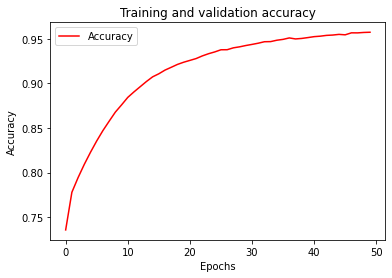

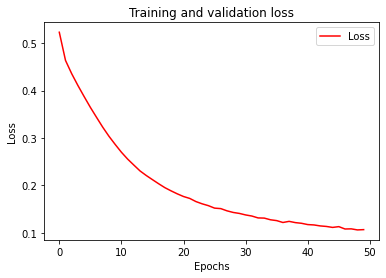

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
# val_acc=history.history['val_accuracy']
loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
# plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
# plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!